<a href="https://colab.research.google.com/github/mhdSharuk/Kaggle-Ion-Switching/blob/master/Ion_Switching_981_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [0]:
import numpy as np 
import numba
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from collections import Counter
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import pywt
from scipy import stats,signal
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(19,6))
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
import lightgbm as lgb
from tqdm import tqdm_notebook
import gc
import warnings 
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from copy import deepcopy
import logging
logger = logging.getLogger('matplotlib.pyplot')
logger.setLevel(logging.CRITICAL)

# Connect to Kaggle CLI

In [45]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"msharuk589","key":"53da20ec2ed73cd7b27a8d01699b16a9"}'}

In [2]:
os.chdir('./drive/My Drive/Ion Switching')
os.listdir()

['train.csv.zip',
 'test.csv.zip',
 'sample_submission.csv.zip',
 'kaggle.json',
 '.ipynb_checkpoints',
 'submission.csv',
 'test_clean.csv',
 'train_clean.csv']

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Helper Functions

In [0]:
def reduce_mem_usage(df: pd.DataFrame,verbose: bool = True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if (c_min > np.iinfo(np.int8).min
                        and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min
                      and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df


In [0]:
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

In [0]:
def mean_abs_dev(val):
  return np.mean(np.absolute(val - np.mean(val)))

In [0]:
def trend(df,abs_value=False):
  idx = np.array(range(len(df)))
  if abs:
    df = np.abs(df)
  lr = LinearRegression()
  lr.fit(idx.reshape(-1,1),df)
  return lr.coef_[0]

In [0]:
def change_rate(df):
    change = (np.diff(df) / df[:-1])
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [0]:
def get_batch(df):
    df.sort_values(by=['time'],inplace=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_0000
    df['batch_index'] = (df.index - (df.batch * 50_000))
    df['batch_slices'] = df['batch_index'] // 5_000
    #df['batch_slices2'] = df['batch'].astype(int).astype(str) + '_' + df['batch_slices'].astype(int).astype(str)

    return df

In [0]:
def get_whole_feat(df,window):
  first_batch = df['batch'].values[0]
  for i in window:
    df[f'rolling_{i}_signal_mean'] = df['signal'].rolling(i).mean().replace([-np.nan,np.nan],df[df['batch'] == first_batch]['signal'].mean())
    df[f'rolling_{i}_signal_std'] = df['signal'].rolling(i).std().replace([-np.nan,np.nan],df[df['batch'] == first_batch]['signal'].std())
    df[f'rolling_{i}_signal_variance'] = df['signal'].rolling(i).var().replace([-np.nan,np.nan],df[df['batch'] == first_batch]['signal'].var())
    df[f'rolling_{i}_signal_min'] = df['signal'].rolling(i).min().replace([-np.nan,np.nan],df[df['batch'] == first_batch]['signal'].min())
    df[f'rolling_{i}_signal_max'] = df['signal'].rolling(i).max().replace([-np.nan,np.nan],df[df['batch'] == first_batch]['signal'].max())
    df[f'rolling_{i}_abs_max_min_distance'] = np.absolute(df[f'rolling_{i}_signal_max'] - df[f'rolling_{i}_signal_min'])
    df[f'rolling_{i}_maxtomin_ratio'] = np.absolute(np.divide(df[f'rolling_{i}_signal_max'],df[f'rolling_{i}_signal_min']))
  return df

In [0]:
def update_df(df,keyval,columns):
  for x in tqdm_notebook(columns):
    if('batch_slices' in str(x)):
      df[x] = df['batch_slices'].map(keyval[x])
    else:
      df[x] = df['batch'].map(keyval[x])
  return df

In [0]:
def get_feat(df,sub=True, replace=True, create_3_state_feat=True, rolling_feat=True,shift_feat=True):
  d={}
  for x in tqdm_notebook(['batch','batch_slices','group']):
    for i in ['mean','median','min','max','sem','skew','mad','std','var']:
      d[f'{x}_{i}'] = df.groupby(x)['signal'].agg(i).to_dict()
    d[f'{x}_mean_abs_diff'] = df.groupby(x)['signal'].apply(lambda x:np.mean(np.abs(np.diff(x))))
    d[f'{x}_max_pos_sig'] = df[df['signal']>0].groupby(x)['signal'].max().to_dict()
    d[f'{x}_min_pos_sig'] = df[df['signal']>0].groupby(x)['signal'].min().to_dict()
    d[f'{x}_max_neg_sig'] = df[df['signal']<0].groupby(x)['signal'].min().to_dict()
    d[f'{x}_min_neg_sig'] = df[df['signal']<0].groupby(x)['signal'].max().to_dict()
    d[f'{x}_first_quant'] = df.groupby(x)['signal'].quantile(q=0.75).to_dict()
    d[f'{x}_third_quant'] = df.groupby(x)['signal'].quantile(q=0.25).to_dict()
    d[f'{x}_mean_absolute_change'] = df.groupby(x)['signal'].apply(lambda x: np.mean(np.abs(np.diff(x)))).to_dict()

  for i in d.keys():
    if 'batch_slices' in i:
      df[i] = df['batch_slices'].map(d[i])
    elif 'batch' in i:
      df[i] = df['batch'].map(d[i])
    else:
      df[i] = df['group'].map(d[i])
  for i in tqdm_notebook(['batch','batch_slices','groups']):
    df[f'{i}_min_max_ratio'] = df[f'{x}_max']/df[f'{x}_min']
    df[f'{i}_min_max_range'] = df[f'{x}_max'] - df[f'{x}_min']
    df[f'{i}_abs_min_max_mean'] = np.abs((df[f'{x}_max'] + df[f'{x}_min'])//2.0)

  if sub:
    for x in [x for x in df.columns if x not in ['time','signal','batch','batch_slices','group','open_channels']]:
      df[f'{x}_msignal'] = df[x] - df['signal']

  if create_3_state_feat:
    for x in tqdm_notebook(['batch','batch_slices','group']):
      df[f'{x}_backward_s1'] = df.groupby(x)['signal'].shift(1)
      df[f'{x}_backward_s2'] = df.groupby(x)['signal'].shift(2)
      df[f'{x}_backward_s3'] = df.groupby(x)['signal'].shift(3)

      df[f'{x}_backward_mean'] = df[[f'{x}_backward_s1',f'{x}_backward_s2',f'{x}_backward_s3']].mean(axis=1)
      df[f'{x}_backward_sum'] = df[[f'{x}_backward_s1',f'{x}_backward_s2',f'{x}_backward_s3']].sum(axis=1)
      df[f'{x}_backward_min'] = df[[f'{x}_backward_s1',f'{x}_backward_s2',f'{x}_backward_s3']].min(axis=1)
      df[f'{x}_backward_max'] = df[[f'{x}_backward_s1',f'{x}_backward_s2',f'{x}_backward_s3']].max(axis=1)

      df[f'{x}_forward_s1'] = df.groupby(x)['signal'].shift(-1)
      df[f'{x}_forward_s2'] = df.groupby(x)['signal'].shift(-2)
      df[f'{x}_forward_s3'] = df.groupby(x)['signal'].shift(-3)

      df[f'{x}_forward_mean'] = df[[f'{x}_forward_s1',f'{x}_forward_s2',f'{x}_forward_s3']].mean(axis=1)
      df[f'{x}_forward_sum'] = df[[f'{x}_forward_s1',f'{x}_forward_s2',f'{x}_forward_s3']].sum(axis=1)
      df[f'{x}_forward_min'] = df[[f'{x}_forward_s1',f'{x}_forward_s2',f'{x}_forward_s3']].min(axis=1)
      df[f'{x}_forward_max'] = df[[f'{x}_forward_s1',f'{x}_forward_s2',f'{x}_forward_s3']].max(axis=1)

  if rolling_feat:
      for x in [50,100,5000,10000]:
        df[f'rolling_{x}_mean'] = df['signal'].rolling(x).mean()

  if shift_feat:
    for x in [-1,-2,-5,-10,1,2,5,10]:
      df[f'shift_{x}'] = df['signal'].shift(x)

  if replace:
    df.fillna(0,inplace=True)
  return df

# Helper Classes

In [0]:
class DataPipeLine:
  def __init__(self):
    pass

  def get_batch(self,df):
    df.sort_values(by=['time'],inplace=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_slices'] = (df.index - (df.batch * 50_000)) // 5000
    return df

  def group_data(self,df_train,df_test,group):
    print(f"Grouping Data {group}")
    self.group = group
    data_groups = (df_train.query(f"group == {self.group}"),df_test.query(f"group == {self.group}"))
    return data_groups
    
  def get_signal_shifting(self,df,window_sizes):
    self.window_shift = window_sizes
    self.df = df
    for i in self.window_shift:
      i = int(i)
      print(f"Shifting Signals {i} size")
      self.df[f'signal_shift_{i}'] = self.df.signal.shift(i)
    return self.df

  def get_features_per_group(self,df,feat_per_batch = False):
    self.data = df
    for x in tqdm_notebook(self.data.group.unique()):
      d = {}
      if not feat_per_batch:
        for i in ['mean','median','std','var','min','max','sem','sum','cumsum','skew','mad']:
          d[f'group_{i}'] = self.data.groupby('group')['signal'].agg(i).to_dict()
        d[f'group_max_neg_signal'] = self.data[self.data['signal']<0].groupby('group')['signal'].min().to_dict()
        d[f'group_min_neg_signal'] = self.data[self.data['signal']<0].groupby('group')['signal'].max().to_dict()
        d[f'group_min_pos_signal'] = self.data[self.data['signal']>0].groupby('group')['signal'].min().to_dict()
        d[f'group_max_pos_signal'] = self.data[self.data['signal']>0].groupby('group')['signal'].max().to_dict()

      else:
        for i in ['batch','batch_slices']:
          for j in ['mean','median','std','var','min','max','sem','sum','cumsum','skew','mad']:
            d[f'group_{i}_{j}'] = self.data.groupby(['group',i])['signal'].agg(j).to_dict()
    return d
  
  def get_batch_feat(self,df):
    d = {}
    for x in tqdm_notebook(['batch','batch_slices']):
      for i in ['mean','median','std','var','min','max','sem','sum','cumsum','skew','mad']:
        d[f'{x}_{i}'] = df.groupby(x)['signal'].agg(i).to_dict()
    return d
  def get_nearest_feat(self,df):
    print("Creating Previous Features")
    df['c1'] = df.groupby('group')['signal'].shift(1) 
    df['c2'] = df.groupby('group')['signal'].shift(2) 
    df['c3'] = df.groupby('group')['signal'].shift(3)

    df['group_prev_3_sum'] = df[['c1','c2','c3']].sum(axis=1)
    df['group_prev_3_mean'] = df[['c1','c2','c3']].mean(axis=1)
    df['group_prev_3_min'] = df[['c1','c2','c3']].min(axis=1)
    df['group_prev_3_max'] = df[['c1','c2','c3']].max(axis=1)
    df['group_prev_3_std'] = df[['c1','c2','c3']].std(axis=1)
    df['group_prev_3_var'] = df[['c1','c2','c3']].var(axis=1)
    df['group_prev_3_mad'] = df[['c1','c2','c3']].mad(axis=1)

    print("Creating Forward Features")
    df['c1'] = df.groupby('group')['signal'].shift(-1) 
    df['c2'] = df.groupby('group')['signal'].shift(-2) 
    df['c3'] = df.groupby('group')['signal'].shift(-3)
    df['group_forw_3_sum'] = df[['c1','c2','c3']].sum(axis=1)
    df['group_forw_3_mean'] = df[['c1','c2','c3']].mean(axis=1)
    df['group_forw_3_min'] = df[['c1','c2','c3']].min(axis=1)
    df['group_forw_3_max'] = df[['c1','c2','c3']].max(axis=1)
    df['group_forw_3_std'] = df[['c1','c2','c3']].std(axis=1)
    df['group_forw_3_var'] = df[['c1','c2','c3']].var(axis=1)
    df['group_forw_3_mad'] = df[['c1','c2','c3']].mad(axis=1)
    df.drop(columns=['c1','c2','c3'],inplace=True)
    return df

pipe = DataPipeLine()

In [0]:
class LGB:
  def __init__(self,train_data,test_data,params,metric):
    self.train = train_data
    self.test = test_data
    self.params = params
    self.metric = metric

  def remove_cols(self,cols):
    print("Removing the inappropriate columns")
    self.used_cols = [x for x in self.train.columns if x not in cols]
    self.train = self.train[self.used_cols]
    self.used_cols.remove('open_channels')
    self.test = self.test[self.used_cols]

  def split_data(self,split_val,for_train=False,for_test=True):
    print("Splitting the data")
    if (for_train == for_test):
      raise "Data Cannot be splitted for both Train and Test Data"
    elif(for_test):
      self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.train[self.used_cols],self.train['open_channels'],test_size=split_val)
    else:
      self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.train[self.used_cols],self.train['open_channels'],train_size=split_val)
  
  def get_params(self):
    return self.params

  def set_params(self,params):
    print("Updated the params values")
    self.params.update(params)

  def eval_metric(self,metric):
    self.eval_metric = metric

  def start_training(self):
    print("Started Training")
    self.model = lgb.train(self.params,
                           lgb.Dataset(self.x_train,self.y_train),
                           2000,lgb.Dataset(self.x_val,self.y_val),
                           verbose_eval=100,
                           early_stopping_rounds=500,feval=self.metric)
  def predict(self):
    print("Predictting the Unknown Data")
    predict_dict = {int(x):0 for x in self.test.index}
    self.predictions = self.model.predict(self.test)
    for (x,y) in enumerate(predict_dict.keys()):
      predict_dict[y] = self.predictions[x] 
    return predict_dict
    

# Loading the data

In [0]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')
sub = pd.read_csv('sample_submission.csv.zip')

test.reset_index(drop=True,inplace=True)

In [0]:
pipe = DataPipeLine()

In [0]:
train = pipe.get_batch(train)
test = pipe.get_batch(test)

In [0]:
train['group'] = -1
x = [(0,500000),(1000000,1500000),(1500000,2000000),(2500000,3000000),(2000000,2500000)]
for k in range(5): train.loc[x[k][0]:x[k][1],'group'] = k

In [0]:
test['group'] = -1
x = [[(0,100000),(300000,400000),(800000,900000),(1000000,2000000)],[(400000,500000)], 
     [(100000,200000),(900000,1000000)],[(200000,300000),(600000,700000)],[(500000,600000),(700000,800000)]]
for k in range(5):
    for j in range(len(x[k])): test.iloc[x[k][j][0]:x[k][j][1],4] = k

In [22]:
gc.collect()

260

In [0]:
#train = train[train['group'] != -1]

In [0]:
%%capture
"""window = [10,25,50,100,5000,10000]
train = get_whole_feat(train,window)
test = get_whole_feat(test,window)

SUB = False
if SUB:
  for i in tqdm_notebook(train.columns[7:]):
    train[str(i) + '_msignal'] = train[str(i)] - train['signal']
    test[str(i) + '_msignal'] = test[str(i)] - test['signal']

train_dict = get_batch_features(train)
test_dict = get_batch_features(test)

dict_columns = list(train_dict.keys())
train = update_df(train,train_dict,dict_columns)
test = update_df(test,test_dict,dict_columns)

train = get_shifting(train)
test = get_shifting(test)
"""

# Data Generation

#### OOP Way

In [0]:
train = pipe.get_signal_shifting(train,(np.linspace(-3,3,7)))

agg_group_feat = pipe.get_features_per_group(train)
for x in tqdm_notebook(agg_group_feat.keys()):
  train[x] = train['group'].map(agg_group_feat[x])
batch_features = pipe.get_batch_feat(train)
for x in tqdm_notebook(batch_features.keys()):
  if 'batch_slices' in x:
    train[x] = train['batch_slices'].map(batch_features[x])
  else:
    train[x] = train['batch'].map(batch_features[x])
train = pipe.get_nearest_feat(train)

Shifting Signals -3 size
Shifting Signals -2 size
Shifting Signals -1 size
Shifting Signals 0 size
Shifting Signals 1 size
Shifting Signals 2 size
Shifting Signals 3 size



Creating Previous Features
Creating Forward Features


In [0]:
test = pipe.get_signal_shifting(test,(np.linspace(-3,3,7)))
agg_group_feat = pipe.get_features_per_group(test)
for x in tqdm_notebook(agg_group_feat.keys()):
  test[x] = test['group'].map(agg_group_feat[x])
batch_features = pipe.get_batch_feat(test)
for x in tqdm_notebook(batch_features.keys()):
  if 'batch_slices' in x:
    test[x] = test['batch_slices'].map(batch_features[x])
  else:
    test[x] = test['batch'].map(batch_features[x])
test = pipe.get_nearest_feat(test)

Shifting Signals -3 size
Shifting Signals -2 size
Shifting Signals -1 size
Shifting Signals 0 size
Shifting Signals 1 size
Shifting Signals 2 size
Shifting Signals 3 size



Creating Previous Features
Creating Forward Features


In [0]:
for df in tqdm_notebook([train,test]):
  for x in ['batch','batch_slices']:
    df[f'{x}_range'] = df[f'{x}_max'] - df[f'{x}_min']
    df[f'{x}_min_max_ratio'] = df[f'{x}_max']/df[f'{x}_min']
    df[f'{x}_abs_max'] = np.absolute(df[f'{x}_max'])
    df[f'{x}_abs_min'] = np.absolute(df[f'{x}_min'])
    df[f'{x}_abs_avg'] = (df[f'{x}_abs_max'] + df[f'{x}_abs_min'])//2 

In [0]:
columns = train.columns[6:]
for df in [train,test]:
  for x in tqdm_notebook(columns):
    df[str(x)+'_msig'] = df[str(x)] - df['signal']

In [0]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [0]:
data_groups = []
for i in [0,1,2,3,4]:
  data_groups.append(pipe.group_data(train,test,i))

Grouping Data 0
Grouping Data 1
Grouping Data 2
Grouping Data 3
Grouping Data 4


In [0]:
gc.collect()
assert train.shape[1]-1 == test.shape[1],"Train and Test shape doesn't match"

90

In [0]:
[x for x in train.columns if x not in test.columns]

['open_channels']

In [0]:
train.head()
test.head()

,time,signal,open_channels,batch,batch_slices,group,signal_shift_-3,signal_shift_-2,signal_shift_-1,signal_shift_0,signal_shift_1,signal_shift_2,signal_shift_3,group_mean,group_median,group_std,group_var,group_min,group_max,group_sem,group_sum,group_cumsum,group_skew,group_mad,group_max_neg_signal,group_min_neg_signal,group_min_pos_signal,group_max_pos_signal,batch_mean,batch_median,batch_std,batch_var,batch_min,batch_max,batch_sem,batch_sum,batch_cumsum,batch_skew,batch_mad,batch_slices_mean,batch_slices_median,batch_slices_std,batch_slices_var,batch_slices_min,batch_slices_max,batch_slices_sem,batch_slices_sum,batch_slices_cumsum,batch_slices_skew,batch_slices_mad,group_prev_3_sum,group_prev_3_mean,group_prev_3_min,group_prev_3_max,group_prev_3_std,group_prev_3_var,group_prev_3_mad,group_forw_3_sum,group_forw_3_mean,group_forw_3_min,group_forw_3_max,group_forw_3_std,group_forw_3_var,group_forw_3_mad,batch_range,batch_min_max_ratio,batch_abs_max,batch_abs_min,batch_abs_avg,batch_slices_range,batch_slices_min_max_ratio,batch_slices_abs_max,batch_slices_abs_min,batch_slices_abs_avg,signal_shift_-3_msig,signal_shift_-2_msig,signal_shift_-1_msig,signal_shift_0_msig,signal_shift_1_msig,signal_shift_2_msig,signal_shift_3_msig,group_mean_msig,group_median_msig,group_std_msig,group_var_msig,group_min_msig,group_max_msig,group_sem_msig,group_sum_msig,group_cumsum_msig,group_skew_msig,group_mad_msig,group_max_neg_signal_msig,group_min_neg_signal_msig,group_min_pos_signal_msig,group_max_pos_signal_msig,batch_mean_msig,batch_median_msig,batch_std_msig,batch_var_msig,batch_min_msig,batch_max_msig,batch_sem_msig,batch_sum_msig,batch_cumsum_msig,batch_skew_msig,batch_mad_msig,batch_slices_mean_msig,batch_slices_median_msig,batch_slices_std_msig,batch_slices_var_msig,batch_slices_min_msig,batch_slices_max_msig,batch_slices_sem_msig,batch_slices_sum_msig,batch_slices_cumsum_msig,batch_slices_skew_msig,batch_slices_mad_msig,group_prev_3_sum_msig,group_prev_3_mean_msig,group_prev_3_min_msig,group_prev_3_max_msig,group_prev_3_std_msig,group_prev_3_var_msig,group_prev_3_mad_msig,group_forw_3_sum_msig,group_forw_3_mean_msig,group_forw_3_min_msig,group_forw_3_max_msig,group_forw_3_std_msig,group_forw_3_var_msig,group_forw_3_mad_msig,batch_range_msig,batch_min_max_ratio_msig,batch_abs_max_msig,batch_abs_min_msig,batch_abs_avg_msig,batch_slices_range_msig,batch_slices_min_max_ratio_msig,batch_slices_abs_max_msig,batch_slices_abs_min_msig,batch_slices_abs_avg_msig
0.0,0.0001,-2.7600,0,0.0,0.0,0,-3.1404,-2.4074,-2.8557,-2.7600,0.0000,0.0000,0.0000,-2.681406,-2.7098,0.32963,0.108656,-3.8506,4.9998,0.000466,-1.340703e+06,-2.76,1.555255,0.231834,-3.8506,-0.4163,0.5864,4.9998,-2.687195,-2.6926,0.260662,0.067945,-3.6621,-0.7651,0.001166,-134359.7694,-2.76,0.671751,0.19908,0.118286,-0.306061,2.526534,6.383376,-5.010298,8.520383,0.003573,59143.009209,-2.76,0.581833,2.155012,0.0000,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,-8.4035,-2.801167,-3.1404,-2.4074,0.369530,0.136553,0.262511,2.897,0.208924,0.7651,3.6621,2.0,13.530681,-1.700574,8.520383,5.010298,6.0,-0.3804,0.3526,-0.0957,0.0,0.0000,0.0000,0.0000,0.078594,0.0502,3.08963,2.868656,-1.0906,7.7598,2.760466,-1.340700e+06,0.0000,4.315255,2.991834,-1.0906,2.3437,3.3464,7.7598,0.072805,0.0674,3.020662,2.827945,-0.9021,1.9949,2.761166,-134357.0094,0.0000,3.431751,2.95908,2.878286,2.453939,5.286534,9.143376,-2.250298,11.280383,2.763573,59145.769209,0.0000,3.341833,4.915012,2.7600,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,-5.6435,-0.041167,-0.3804,0.3526,3.129530,2.896553,3.022511,5.6570,2.968924,3.5251,6.4221,4.7600,16.290681,1.059426,11.280383,7.770298,8.7600
1.0,0.0002,-2.8557,0,0.0,0.0,0,-3.1525,-3.1404,-2.4074,-2.8557,-2.7600,0.0000,0.0000,-2.681406,-2.7098,0.32963,0.108656,-3.8506,4.9998,0.000466,-1.340703e+06,-2.76,1.555255,0.231834,-3.8506,-0.4163,0.5864,4.9998,-2.687195,-2.6926,0.260662,0.067945,-3.6621,-0.7651,0.001166,-134359.7694,-2.76,0.671751,0.19908,0.118286,-0.306061,2.526534,6.383376

,time,signal,batch,batch_slices,group,signal_shift_-3,signal_shift_-2,signal_shift_-1,signal_shift_0,signal_shift_1,signal_shift_2,signal_shift_3,group_mean,group_median,group_std,group_var,group_min,group_max,group_sem,group_sum,group_cumsum,group_skew,group_mad,group_max_neg_signal,group_min_neg_signal,group_min_pos_signal,group_max_pos_signal,batch_mean,batch_median,batch_std,batch_var,batch_min,batch_max,batch_sem,batch_sum,batch_cumsum,batch_skew,batch_mad,batch_slices_mean,batch_slices_median,batch_slices_std,batch_slices_var,batch_slices_min,batch_slices_max,batch_slices_sem,batch_slices_sum,batch_slices_cumsum,batch_slices_skew,batch_slices_mad,group_prev_3_sum,group_prev_3_mean,group_prev_3_min,group_prev_3_max,group_prev_3_std,group_prev_3_var,group_prev_3_mad,group_forw_3_sum,group_forw_3_mean,group_forw_3_min,group_forw_3_max,group_forw_3_std,group_forw_3_var,group_forw_3_mad,batch_range,batch_min_max_ratio,batch_abs_max,batch_abs_min,batch_abs_avg,batch_slices_range,batch_slices_min_max_ratio,batch_slices_abs_max,batch_slices_abs_min,batch_slices_abs_avg,signal_shift_-3_msig,signal_shift_-2_msig,signal_shift_-1_msig,signal_shift_0_msig,signal_shift_1_msig,signal_shift_2_msig,signal_shift_3_msig,group_mean_msig,group_median_msig,group_std_msig,group_var_msig,group_min_msig,group_max_msig,group_sem_msig,group_sum_msig,group_cumsum_msig,group_skew_msig,group_mad_msig,group_max_neg_signal_msig,group_min_neg_signal_msig,group_min_pos_signal_msig,group_max_pos_signal_msig,batch_mean_msig,batch_median_msig,batch_std_msig,batch_var_msig,batch_min_msig,batch_max_msig,batch_sem_msig,batch_sum_msig,batch_cumsum_msig,batch_skew_msig,batch_mad_msig,batch_slices_mean_msig,batch_slices_median_msig,batch_slices_std_msig,batch_slices_var_msig,batch_slices_min_msig,batch_slices_max_msig,batch_slices_sem_msig,batch_slices_sum_msig,batch_slices_cumsum_msig,batch_slices_skew_msig,batch_slices_mad_msig,group_prev_3_sum_msig,group_prev_3_mean_msig,group_prev_3_min_msig,group_prev_3_max_msig,group_prev_3_std_msig,group_prev_3_var_msig,group_prev_3_mad_msig,group_forw_3_sum_msig,group_forw_3_mean_msig,group_forw_3_min_msig,group_forw_3_max_msig,group_forw_3_std_msig,group_forw_3_var_msig,group_forw_3_mad_msig,batch_range_msig,batch_min_max_ratio_msig,batch_abs_max_msig,batch_abs_min_msig,batch_abs_avg_msig,batch_slices_range_msig,batch_slices_min_max_ratio_msig,batch_slices_abs_max_msig,batch_slices_abs_min_msig,batch_slices_abs_avg_msig
5000000.0,500.0001,-2.675347,100.0,0.0,0,-2.460642,-2.885611,-2.874979,-2.675347,0.000000,0.000000,0.000000,-2.608839,-2.691547,0.451118,0.203507,-4.02583,2.614572,0.000396,-3.391490e+06,0.0,2.111288,0.298869,-4.02583,-0.000034,0.000088,2.614572,-2.656914,-2.702127,0.36147,0.130661,-3.843894,-0.639844,0.001617,-132845.697453,0.0,1.690066,0.247964,-1.297884,-2.520908,2.297052,5.27645,-3.816583,8.430978,0.005136,-259576.844775,0.0,1.511498,1.833552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.221232,-2.740411,-2.885611,-2.460642,0.242345,0.058731,0.186512,3.204051,0.166457,0.639844,3.843894,2.0,12.247561,-2.209038,8.430978,3.816583,6.0,0.214705,-0.210263,-0.199632,0.0,0.000000,0.000000,0.000000,0.066508,-0.016200,3.126465,2.878855,-1.350483,5.289920,2.675743,-3.391488e+06,0.0,4.786635,2.974216,-1.350483,2.675314,2.675435,5.289920,0.018433,-0.026780,3.036817,2.806008,-1.168547,2.035504,2.676964,-132843.022106,0.0,4.365414,2.923311,1.377463,0.154439,4.972400,7.951797,-1.141235,11.106325,2.680484,-259574.169428,0.0,4.186845,4.508899,2.675347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.545884,-0.065063,-0.210263,0.214705,2.917692,2.734078,2.861860,5.879398,2.841804,3.315191,6.519242,4.675347,14.922908,0.466309,11.106325,6.491930,8.675347
5000001.0,500.0002,-2.874979,100.0,0.0,0,-2.641174,-2.460642,-2.885611,-2.874979,-2.675347,0.000000,0.000000,-2.608839,-2.691547,0.451118,0.203507,-4.02583,2.614572,0.000396,-3.391490e+06,0.0,2.111288,0.298869,-4.02583,-0.000034,0.000088,2.6145

In [0]:
a = int(train.shape[0] - train.shape[0]*0.1)
a

4500000

In [0]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1580.97 MB (71.8 % reduction)
Mem. usage decreased to 654.11 MB (70.9 % reduction)


In [0]:
params = {'learning_rate': 0.07, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 7, 
          'n_jobs':-1, 
          'sample_fraction':0.33}
gc.collect()

0

In [0]:
for i in range(0,5):
  print(data_groups[i][0].group.unique(),
        data_groups[i][1].group.unique())

[0] [0]
[1] [1]
[2] [2]
[3] [3]
[4] [4]


In [0]:
cols = ['time', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']
model_group_0 = LGB(data_groups[0][0],data_groups[0][1],params,MacroF1Metric)
model_group_1 = LGB(data_groups[1][0],data_groups[1][1],params,MacroF1Metric)
model_group_2 = LGB(data_groups[2][0],data_groups[2][1],params,MacroF1Metric)
model_group_3 = LGB(data_groups[3][0],data_groups[3][1],params,MacroF1Metric)
model_group_4 = LGB(data_groups[4][0],data_groups[4][1],params,MacroF1Metric)

In [0]:
model_group_0.remove_cols(cols)
model_group_1.remove_cols(cols)
model_group_2.remove_cols(cols)
model_group_3.remove_cols(cols)
model_group_4.remove_cols(cols)

Removing the inappropriate columns
Removing the inappropriate columns
Removing the inappropriate columns
Removing the inappropriate columns
Removing the inappropriate columns


In [0]:
SPLIT = 0.15
model_group_0.split_data(SPLIT)
model_group_1.split_data(SPLIT)
model_group_2.split_data(SPLIT)
model_group_3.split_data(SPLIT)
model_group_4.split_data(SPLIT)

Splitting the data
Splitting the data
Splitting the data
Splitting the data
Splitting the data


In [0]:
predictions_dict = {x:0 for x in test.index}
len(predictions_dict.values())

2000000

In [0]:
model_group_0.start_training()
predictions_dict.update(model_group_0.predict())

Started Training
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's MacroF1Metric: 0.996602
[200]	valid_0's MacroF1Metric: 0.996602
[300]	valid_0's MacroF1Metric: 0.996491
[400]	valid_0's MacroF1Metric: 0.996491
[500]	valid_0's MacroF1Metric: 0.996491
Early stopping, best iteration is:
[24]	valid_0's MacroF1Metric: 0.997038
Predictting the Unknown Data


In [0]:
model_group_1.start_training()
predictions_dict.update(model_group_1.predict())
model_group_2.start_training()
predictions_dict.update(model_group_2.predict())
model_group_3.start_training()
predictions_dict.update(model_group_3.predict())
model_group_4.start_training()
predictions_dict.update(model_group_4.predict())

Started Training
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's MacroF1Metric: 0.996915
[200]	valid_0's MacroF1Metric: 0.996879
[300]	valid_0's MacroF1Metric: 0.996844
[400]	valid_0's MacroF1Metric: 0.996861
[500]	valid_0's MacroF1Metric: 0.996861
Early stopping, best iteration is:
[29]	valid_0's MacroF1Metric: 0.997162
Predictting the Unknown Data
Started Training
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's MacroF1Metric: 0.984587
[200]	valid_0's MacroF1Metric: 0.984864
[300]	valid_0's MacroF1Metric: 0.984883
[400]	valid_0's MacroF1Metric: 0.98486
[500]	valid_0's MacroF1Metric: 0.984694
[600]	valid_0's MacroF1Metric: 0.984656
[700]	valid_0's MacroF1Metric: 0.984722
[800]	valid_0's MacroF1Metric: 0.984577
Early stopping, best iteration is:
[334]	valid_0's MacroF1Metric: 0.984937
Predictting the Unknown Data
Started Training
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's MacroF1Metric: 0.9

In [0]:
preds = [x for (y,x) in predictions_dict.items()]

In [0]:
round_pred = np.round(np.clip(preds[:2000000], 0, 10)).astype(int)
sub['open_channels'] = round_pred
sub['open_channels'].value_counts()
sub.to_csv('submission.csv', index=False, float_format='%.4f')

#### Functional Way

In [25]:
train = get_feat(train,sub=True,replace=True,create_3_state_feat=True,rolling_feat=True,shift_feat=True)
gc.collect()

4

In [26]:
test = get_feat(test,sub=True,replace=True,create_3_state_feat=True,rolling_feat=True,shift_feat=True)
gc.collect()

8

In [27]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1905.22 MB (73.0 % reduction)
Mem. usage decreased to 776.18 MB (72.5 % reduction)


In [28]:
print(f'train shape => {train.shape}')
print(f'test shape => {test.shape}')

train shape => (5000000, 180)
test shape => (2000000, 179)


In [31]:
train.head()
test.head()

,time,signal,open_channels,batch,batch_slices,group,batch_mean,batch_median,batch_min,batch_max,batch_sem,batch_skew,batch_mad,batch_std,batch_var,batch_mean_abs_diff,batch_max_pos_sig,batch_min_pos_sig,batch_max_neg_sig,batch_min_neg_sig,batch_first_quant,batch_third_quant,batch_mean_absolute_change,batch_slices_mean,batch_slices_median,batch_slices_min,batch_slices_max,batch_slices_sem,batch_slices_skew,batch_slices_mad,batch_slices_std,batch_slices_var,batch_slices_mean_abs_diff,batch_slices_max_pos_sig,batch_slices_min_pos_sig,batch_slices_max_neg_sig,batch_slices_min_neg_sig,batch_slices_first_quant,batch_slices_third_quant,batch_slices_mean_absolute_change,group_mean,group_median,group_min,group_max,group_sem,group_skew,group_mad,group_std,group_var,group_mean_abs_diff,group_max_pos_sig,group_min_pos_sig,group_max_neg_sig,group_min_neg_sig,group_first_quant,group_third_quant,group_mean_absolute_change,batch_min_max_ratio,batch_min_max_range,batch_abs_min_max_mean,batch_slices_min_max_ratio,batch_slices_min_max_range,batch_slices_abs_min_max_mean,groups_min_max_ratio,groups_min_max_range,groups_abs_min_max_mean,batch_mean_msignal,batch_median_msignal,batch_min_msignal,batch_max_msignal,batch_sem_msignal,batch_skew_msignal,batch_mad_msignal,batch_std_msignal,batch_var_msignal,batch_mean_abs_diff_msignal,batch_max_pos_sig_msignal,batch_min_pos_sig_msignal,batch_max_neg_sig_msignal,batch_min_neg_sig_msignal,batch_first_quant_msignal,batch_third_quant_msignal,batch_mean_absolute_change_msignal,batch_slices_mean_msignal,batch_slices_median_msignal,batch_slices_min_msignal,batch_slices_max_msignal,batch_slices_sem_msignal,batch_slices_skew_msignal,batch_slices_mad_msignal,batch_slices_std_msignal,batch_slices_var_msignal,batch_slices_mean_abs_diff_msignal,batch_slices_max_pos_sig_msignal,batch_slices_min_pos_sig_msignal,batch_slices_max_neg_sig_msignal,batch_slices_min_neg_sig_msignal,batch_slices_first_quant_msignal,batch_slices_third_quant_msignal,batch_slices_mean_absolute_change_msignal,group_mean_msignal,group_median_msignal,group_min_msignal,group_max_msignal,group_sem_msignal,group_skew_msignal,group_mad_msignal,group_std_msignal,group_var_msignal,group_mean_abs_diff_msignal,group_max_pos_sig_msignal,group_min_pos_sig_msignal,group_max_neg_sig_msignal,group_min_neg_sig_msignal,group_first_quant_msignal,group_third_quant_msignal,group_mean_absolute_change_msignal,batch_min_max_ratio_msignal,batch_min_max_range_msignal,batch_abs_min_max_mean_msignal,batch_slices_min_max_ratio_msignal,batch_slices_min_max_range_msignal,batch_slices_abs_min_max_mean_msignal,groups_min_max_ratio_msignal,groups_min_max_range_msignal,groups_abs_min_max_mean_msignal,batch_backward_s1,batch_backward_s2,batch_backward_s3,batch_backward_mean,batch_backward_sum,batch_backward_min,batch_backward_max,batch_forward_s1,batch_forward_s2,batch_forward_s3,batch_forward_mean,batch_forward_sum,batch_forward_min,batch_forward_max,batch_slices_backward_s1,batch_slices_backward_s2,batch_slices_backward_s3,batch_slices_backward_mean,batch_slices_backward_sum,batch_slices_backward_min,batch_slices_backward_max,batch_slices_forward_s1,batch_slices_forward_s2,batch_slices_forward_s3,batch_slices_forward_mean,batch_slices_forward_sum,batch_slices_forward_min,batch_slices_forward_max,group_backward_s1,group_backward_s2,group_backward_s3,group_backward_mean,group_backward_sum,group_backward_min,group_backward_max,group_forward_s1,group_forward_s2,group_forward_s3,group_forward_mean,group_forward_sum,group_forward_min,group_forward_max,rolling_50_mean,rolling_100_mean,rolling_5000_mean,rolling_10000_mean,shift_-1,shift_-2,shift_-5,shift_-10,shift_1,shift_2,shift_5,shift_10
0.0,0.0001,-2.759766,0,0.0,0.0,0,-2.6875,-2.693359,-3.662109,-0.765137,0.001165,0.671875,0.199097,0.260742,0.067932,0.270264,0.0,0.0,-3.662109,-0.765137,-2.529297,-2.855469,0.270264,0.11322,-0.306885,-5.0,8.515625,0.003565,0.580078,2.150391,2.519531,6.351562,0.616699,8.515625,7.152557e-07,-5.0,-0.000

,time,signal,batch,batch_slices,group,batch_mean,batch_median,batch_min,batch_max,batch_sem,batch_skew,batch_mad,batch_std,batch_var,batch_mean_abs_diff,batch_max_pos_sig,batch_min_pos_sig,batch_max_neg_sig,batch_min_neg_sig,batch_first_quant,batch_third_quant,batch_mean_absolute_change,batch_slices_mean,batch_slices_median,batch_slices_min,batch_slices_max,batch_slices_sem,batch_slices_skew,batch_slices_mad,batch_slices_std,batch_slices_var,batch_slices_mean_abs_diff,batch_slices_max_pos_sig,batch_slices_min_pos_sig,batch_slices_max_neg_sig,batch_slices_min_neg_sig,batch_slices_first_quant,batch_slices_third_quant,batch_slices_mean_absolute_change,group_mean,group_median,group_min,group_max,group_sem,group_skew,group_mad,group_std,group_var,group_mean_abs_diff,group_max_pos_sig,group_min_pos_sig,group_max_neg_sig,group_min_neg_sig,group_first_quant,group_third_quant,group_mean_absolute_change,batch_min_max_ratio,batch_min_max_range,batch_abs_min_max_mean,batch_slices_min_max_ratio,batch_slices_min_max_range,batch_slices_abs_min_max_mean,groups_min_max_ratio,groups_min_max_range,groups_abs_min_max_mean,batch_mean_msignal,batch_median_msignal,batch_min_msignal,batch_max_msignal,batch_sem_msignal,batch_skew_msignal,batch_mad_msignal,batch_std_msignal,batch_var_msignal,batch_mean_abs_diff_msignal,batch_max_pos_sig_msignal,batch_min_pos_sig_msignal,batch_max_neg_sig_msignal,batch_min_neg_sig_msignal,batch_first_quant_msignal,batch_third_quant_msignal,batch_mean_absolute_change_msignal,batch_slices_mean_msignal,batch_slices_median_msignal,batch_slices_min_msignal,batch_slices_max_msignal,batch_slices_sem_msignal,batch_slices_skew_msignal,batch_slices_mad_msignal,batch_slices_std_msignal,batch_slices_var_msignal,batch_slices_mean_abs_diff_msignal,batch_slices_max_pos_sig_msignal,batch_slices_min_pos_sig_msignal,batch_slices_max_neg_sig_msignal,batch_slices_min_neg_sig_msignal,batch_slices_first_quant_msignal,batch_slices_third_quant_msignal,batch_slices_mean_absolute_change_msignal,group_mean_msignal,group_median_msignal,group_min_msignal,group_max_msignal,group_sem_msignal,group_skew_msignal,group_mad_msignal,group_std_msignal,group_var_msignal,group_mean_abs_diff_msignal,group_max_pos_sig_msignal,group_min_pos_sig_msignal,group_max_neg_sig_msignal,group_min_neg_sig_msignal,group_first_quant_msignal,group_third_quant_msignal,group_mean_absolute_change_msignal,batch_min_max_ratio_msignal,batch_min_max_range_msignal,batch_abs_min_max_mean_msignal,batch_slices_min_max_ratio_msignal,batch_slices_min_max_range_msignal,batch_slices_abs_min_max_mean_msignal,groups_min_max_ratio_msignal,groups_min_max_range_msignal,groups_abs_min_max_mean_msignal,batch_backward_s1,batch_backward_s2,batch_backward_s3,batch_backward_mean,batch_backward_sum,batch_backward_min,batch_backward_max,batch_forward_s1,batch_forward_s2,batch_forward_s3,batch_forward_mean,batch_forward_sum,batch_forward_min,batch_forward_max,batch_slices_backward_s1,batch_slices_backward_s2,batch_slices_backward_s3,batch_slices_backward_mean,batch_slices_backward_sum,batch_slices_backward_min,batch_slices_backward_max,batch_slices_forward_s1,batch_slices_forward_s2,batch_slices_forward_s3,batch_slices_forward_mean,batch_slices_forward_sum,batch_slices_forward_min,batch_slices_forward_max,group_backward_s1,group_backward_s2,group_backward_s3,group_backward_mean,group_backward_sum,group_backward_min,group_backward_max,group_forward_s1,group_forward_s2,group_forward_s3,group_forward_mean,group_forward_sum,group_forward_min,group_forward_max,rolling_50_mean,rolling_100_mean,rolling_5000_mean,rolling_10000_mean,shift_-1,shift_-2,shift_-5,shift_-10,shift_1,shift_2,shift_5,shift_10
0,500.0,-2.650391,100.0,0.0,0,-2.630859,-2.677734,-3.818359,-0.614746,0.001616,1.689453,0.247925,0.361328,0.130615,0.28418,0.0,0.0,-3.818359,-0.614746,-2.498047,-2.847656,0.28418,-1.295898,-2.513672,-3.794922,8.40625,0.005123,1.511719,1.828125,2.291016,5.25,0.440186,8.40625,0.000003,-3.794922,-0.00012,-0.290283,-2

In [0]:
SAVE = False
if SAVE:
  x_train.to_csv('train_v1.csv',index=False)
  y_train.to_csv('train_targ_v1.csv',index=False)
  x_val.to_csv('val_v1.csv',index=False)
  y_val.to_csv('val_targ_v1.csv',index=False)

In [100]:
split_value = train.shape[0] - train.shape[0]*0.1
split_value

4500000.0

In [0]:
use_cols = [x for x in train.columns if x not in ['time', 'open_channels', 'batch', 'batch_slices', 'group']]

In [33]:
x_train,x_val,y_train,y_val = train_test_split(train[use_cols],train['open_channels'],test_size=0.15)
print(f'x_train shape => {x_train.shape[0]}, y_train shape => {y_train.shape}')

x_train shape => 4250000, y_train shape => (4250000,)


In [0]:
params = {'learning_rate': 0.07, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 7, 
          'n_jobs':-1, 
          'sample_fraction':0.33}

gc.collect()

In [37]:
model = lgb.train(params, lgb.Dataset(x_train, y_train), 2000,  lgb.Dataset(x_val, y_val), verbose_eval=50, early_stopping_rounds=500, feval=MacroF1Metric)

Training until validation scores don't improve for 500 rounds.
[50]	valid_0's MacroF1Metric: 0.934603
[100]	valid_0's MacroF1Metric: 0.937915
[150]	valid_0's MacroF1Metric: 0.938053
[200]	valid_0's MacroF1Metric: 0.937932
[250]	valid_0's MacroF1Metric: 0.938037
[300]	valid_0's MacroF1Metric: 0.938017
[350]	valid_0's MacroF1Metric: 0.93804
[400]	valid_0's MacroF1Metric: 0.938026
[450]	valid_0's MacroF1Metric: 0.938104
[500]	valid_0's MacroF1Metric: 0.938063
[550]	valid_0's MacroF1Metric: 0.937965
[600]	valid_0's MacroF1Metric: 0.938
[650]	valid_0's MacroF1Metric: 0.938041
[700]	valid_0's MacroF1Metric: 0.938071
[750]	valid_0's MacroF1Metric: 0.938102
[800]	valid_0's MacroF1Metric: 0.938074
[850]	valid_0's MacroF1Metric: 0.93807
[900]	valid_0's MacroF1Metric: 0.938079
[950]	valid_0's MacroF1Metric: 0.937944
[1000]	valid_0's MacroF1Metric: 0.93794
[1050]	valid_0's MacroF1Metric: 0.937922
[1100]	valid_0's MacroF1Metric: 0.937984
[1150]	valid_0's MacroF1Metric: 0.938018
[1200]	valid_0's Mac

In [0]:
preds = model.predict(test[use_cols], num_iteration=model.best_iteration)

# Submtting the Predictions

In [41]:
round_pred = np.round(np.clip(preds, 0, 10)).astype(int)
sub['open_channels'] = round_pred
sub['open_channels'].value_counts()

0     1219114
1      223581
3      135462
2      111517
4       80317
5       55585
7       53281
8       49699
6       36757
9       27500
10       7187
Name: open_channels, dtype: int64

In [0]:
sub.to_csv('submission.csv', index=False, float_format='%.4f')

In [48]:
!kaggle competitions submit -c liverpool-ion-switching -f submission.csv -m "cv 0.9381"

100% 21.0M/21.0M [00:05<00:00, 3.88MB/s]
Successfully submitted to University of Liverpool - Ion Switching

# Feature Importance Scale

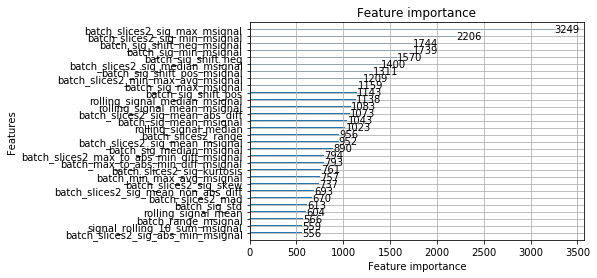

In [0]:
lgb.plot_importance(model,importance_type='split', max_num_features=30)

# ANALYSIS

#### For Train Data

In [0]:
train.head()
train2 = train.copy()

,time,signal,open_channels,batch,batch_index,batch_slices,batch_slices2
0.0,0.0001,-2.7600,0,0.0,0.0,0.0,0_0
1.0,0.0002,-2.8557,0,0.0,1.0,0.0,0_0
2.0,0.0003,-2.4074,0,0.0,2.0,0.0,0_0
3.0,0.0004,-3.1404,0,0.0,3.0,0.0,0_0
4.0,0.0005,-3.1525,0,0.0,4.0,0.0,0_0


Text(200000.0, 10, '1')

Text(700000.0, 10, '2')

Text(1200000.0, 10, '3')

Text(1700000.0, 10, '4')

Text(2200000.0, 10, '5')

Text(2700000.0, 10, '6')

Text(3200000.0, 10, '7')

Text(3700000.0, 10, '8')

Text(4200000.0, 10, '9')

Text(4700000.0, 10, '10')

([<matplotlib.axis.YTick at 0x7f0e6ccc95f8>,
 <a list of 17 Text major ticklabel objects>)

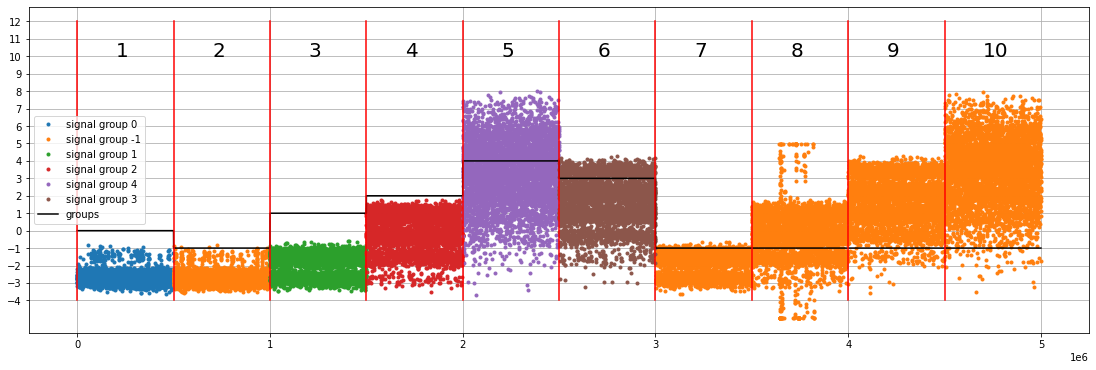

In [0]:
for x in train.group.unique():
  plt.plot(train[train['group'] == x]['signal'][::100],'.',label=f'signal group {x}')
plt.plot(train['group'],label='groups',color='black')
for i in range(10):
  plt.plot([i*5e5,i*5e5],[-4,12],'r')
for i in range(10):
  plt.text(i*5e5+2e5,10,str(i+1),size=20)
plt.yticks(np.linspace(-4,12,17))
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1368x432 with 0 Axes>

([<matplotlib.axis.YTick at 0x7f22613d80b8>,
 <a list of 11 Text yticklabel objects>)

Text(200000, 10, '1')

Text(700000, 10, '2')

Text(1200000, 10, '3')

Text(1700000, 10, '4')

Text(2200000, 10, '5')

Text(2700000, 10, '6')

Text(3200000, 10, '7')

Text(3700000, 10, '8')

Text(4200000, 10, '9')

Text(4700000, 10, '10')

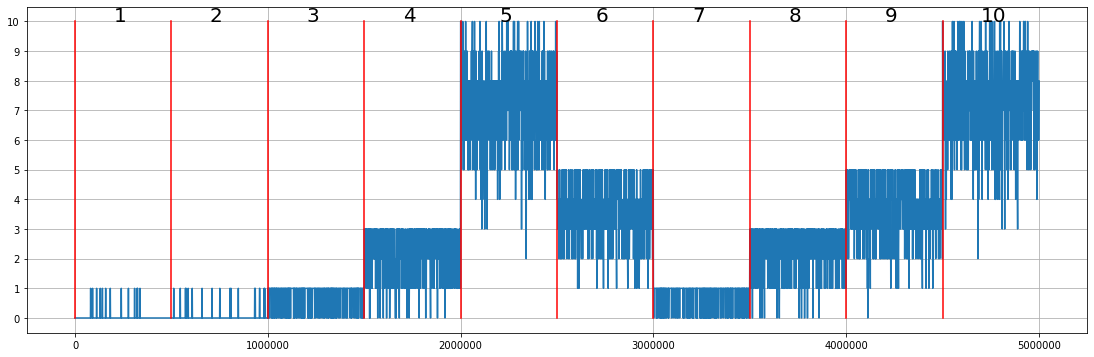

In [0]:
%matplotlib inline
plt.figure(figsize=(19,6))
res = 1000
plt.plot(range(0,train.shape[0],res),train['open_channels'][0::res])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
for i in range(10):
  plt.plot([i*5e5,i*5e5],[0,10],'r')
for i in range(10):
  plt.text(i*500000+200000,10,str(i+1),size=20)
plt.grid()
plt.show()

<Figure size 1368x360 with 0 Axes>

Text(200000, 10, '1')

Text(700000, 10, '2')

Text(1200000, 10, '3')

Text(1700000, 10, '4')

Text(2200000, 10, '5')

Text(2700000, 10, '6')

Text(3200000, 10, '7')

Text(3700000, 10, '8')

Text(4200000, 10, '9')

Text(4700000, 10, '10')

([<matplotlib.axis.XTick at 0x7f22614920b8>,
 <a list of 11 Text xticklabel objects>)

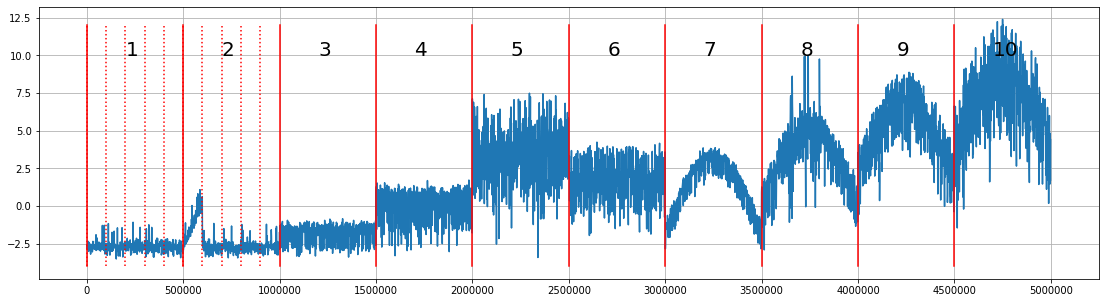

In [0]:
%matplotlib inline
plt.figure(figsize=(19,5)) 
res = 1000
plt.plot(range(0,train.shape[0],res),train['signal'][0::res])
for i in range(10):
  plt.plot([i*500000,i*500000],[-4,12],'r')
for j in range(10):
    plt.plot([j*100000,j*100000],[-4,12],'r:')
for i in range(10):
  plt.text(i*500000+200000,10,str(i+1),size=20)
plt.xticks(np.linspace(0,5e6,11))
plt.grid()
plt.show()

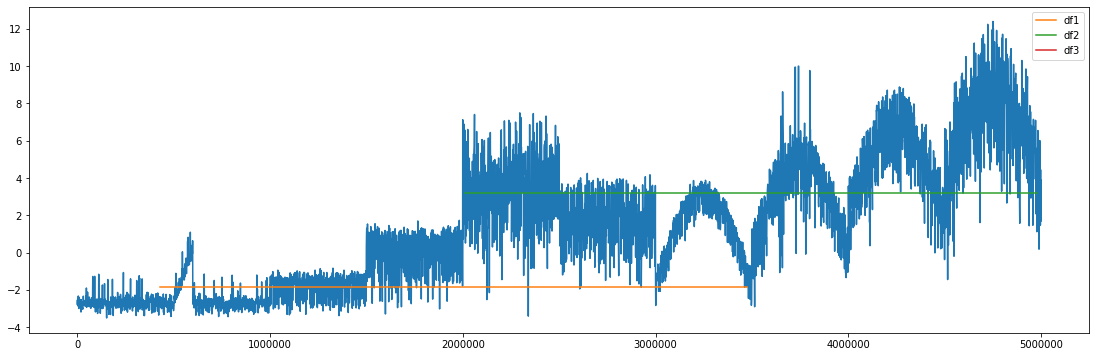

In [0]:
df1 = train[train['signal'] == -1.817]
df2 = train[train['signal'] == 3.186]
df3 = train[train['signal'] == 325]

plt.plot(train['signal'][::1000],alpha=1)
plt.plot(df1['signal'],alpha=1,label='df1')
plt.plot(df2['signal'],alpha=1,label='df2')
plt.plot(df3['signal'],alpha=1,label='df3')
plt.legend()

In [0]:
slope, intercept, rval, pval, stderr = stats.linregress(train['time'][5e5:6e5],np.array(pd.Series(train['signal'][5e5:6e5].rolling(1000).mean()).replace(np.nan,0)))
print(slope," ",intercept)

0.2780586831290444   -16.412697803386518


<Figure size 1368x360 with 0 Axes>

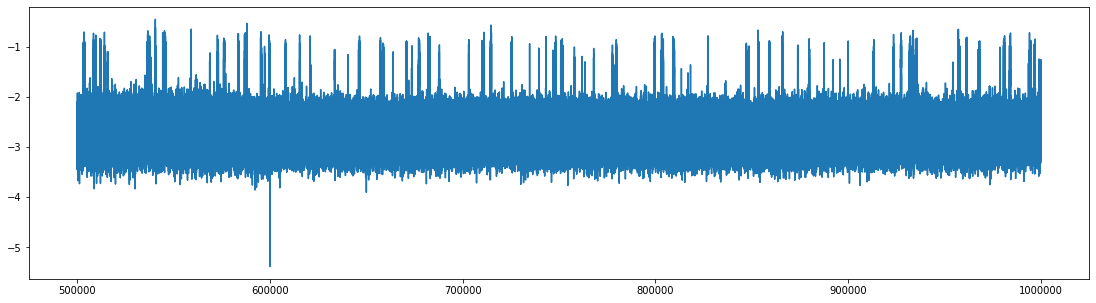

In [0]:
train2 = train.copy()
a = 5e5;b1=6e5;b2=1e6
train2.loc[a:b1,'signal'] = train2.loc[a:b1,'signal'] - ((np.ceil(slope*10)/10)*(train2.loc[a:b1,'time']) - 15)
plt.figure(figsize=(19,5))
plt.plot(train2.loc[a:b2,'signal'])

<Figure size 1368x360 with 0 Axes>

Text(0.5, 1.0, 'Signals with Drift in Batch 2')

<Figure size 1368x360 with 0 Axes>

Text(0.5, 1.0, 'Signals without Drift in Batch 2')

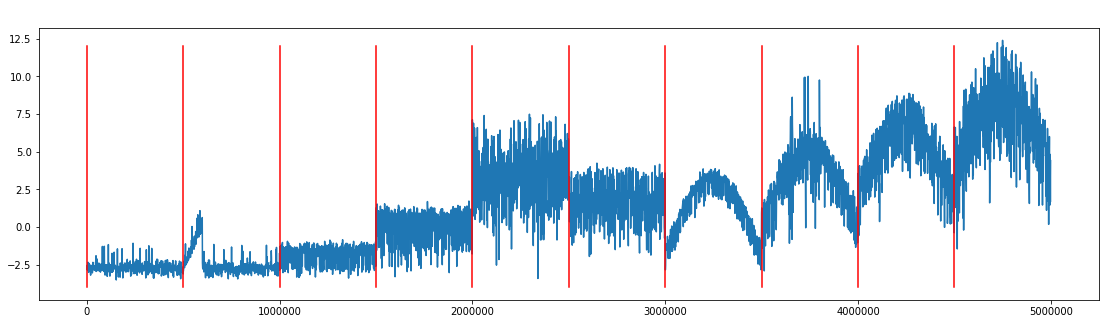

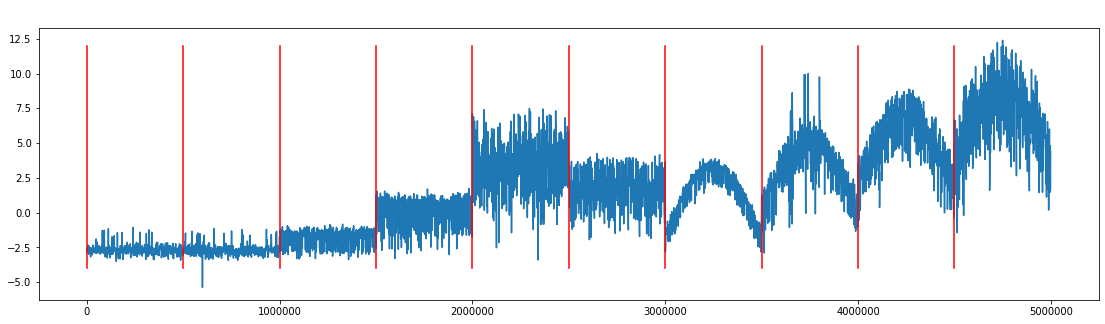

In [0]:
plt.figure(figsize=(19,5))
plt.title("Signals with Drift in Batch 2",color='white',size=20)
plt.plot(train['signal'][::1000])
for i in range(10):
  plt.plot([i*5e5,i*5e5],[-4,12],'r')

plt.figure(figsize=(19,5))
plt.title("Signals without Drift in Batch 2",color='white',size=20)
plt.plot(train2['signal'][::1000])
for i in range(10):
  plt.plot([i*5e5,i*5e5],[-4,12],'r')
plt.show()

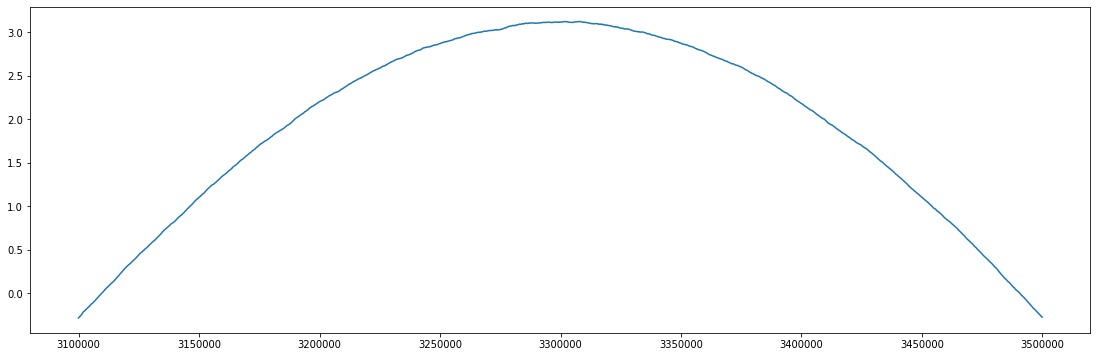

In [0]:
plt.plot(train[train['batch'] == 6]['signal'][::100].rolling(1000).mean())

In [0]:
train_c = pd.read_csv('train_clean.csv')
train_c = get_batch(train_c)
train_c.head()

,time,signal,open_channels,batch,batch_index,batch_slices,batch_slices2
0.0,0.0001,-2.7600,0,0.0,0.0,0.0,0_0
1.0,0.0002,-2.8557,0,0.0,1.0,0.0,0_0
2.0,0.0003,-2.4074,0,0.0,2.0,0.0,0_0
3.0,0.0004,-3.1404,0,0.0,3.0,0.0,0_0
4.0,0.0005,-3.1525,0,0.0,4.0,0.0,0_0


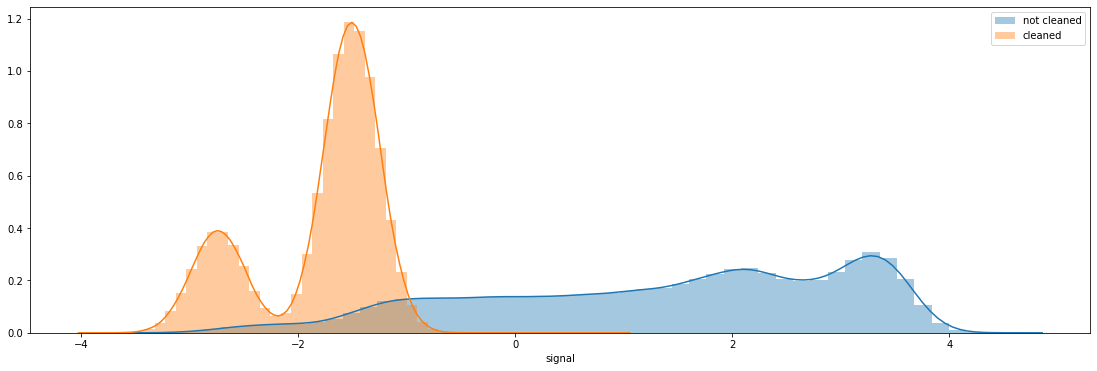

In [0]:
sns.distplot(train[train['batch'] == 6]['signal'],label='not cleaned')
sns.distplot(train_c[train_c['batch'] == 6]['signal'],label='cleaned')
plt.legend()
plt.show()

<Figure size 1440x720 with 0 Axes>

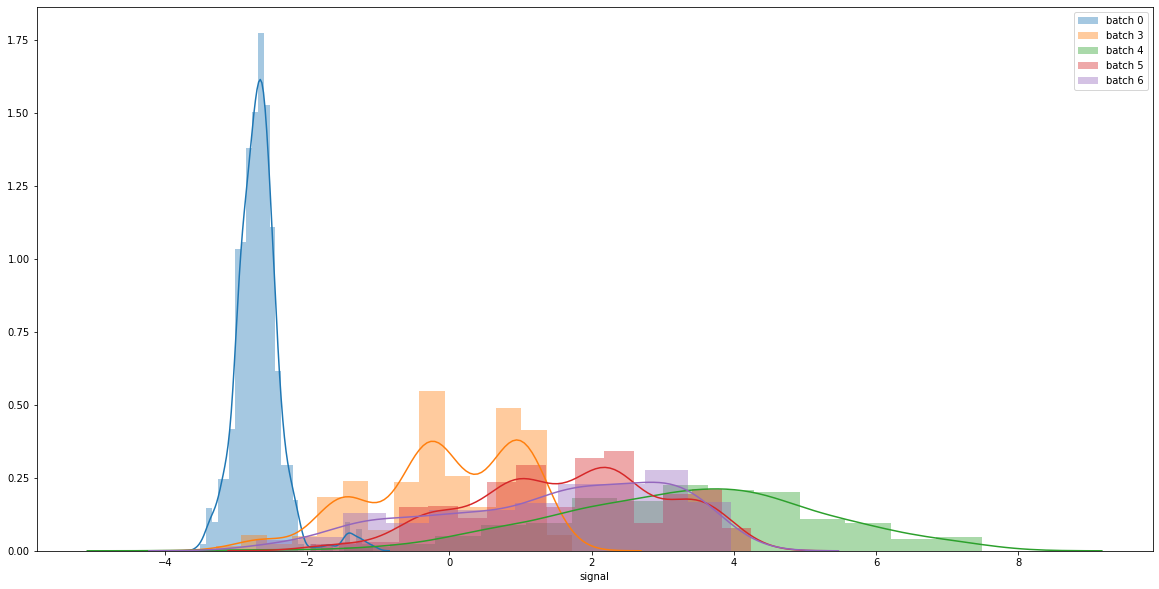

In [0]:
plt.figure(figsize=(20,10))
for i in [0,3,4,5,6]:
  sns.distplot(train[train['batch'] == i]['signal'][::1000],label=f'batch {i}')
plt.legend()
plt.show()

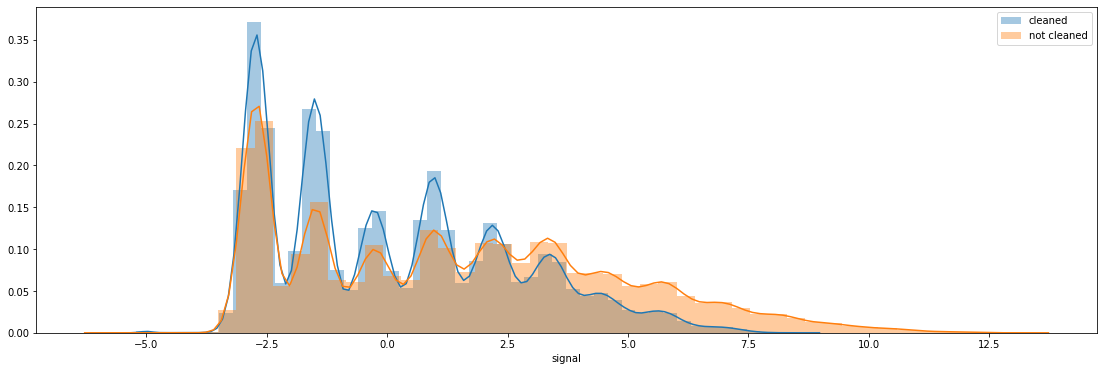

In [0]:
sns.distplot(train_c['signal'],label='cleaned')
sns.distplot(train['signal'],label='not cleaned')
plt.legend()

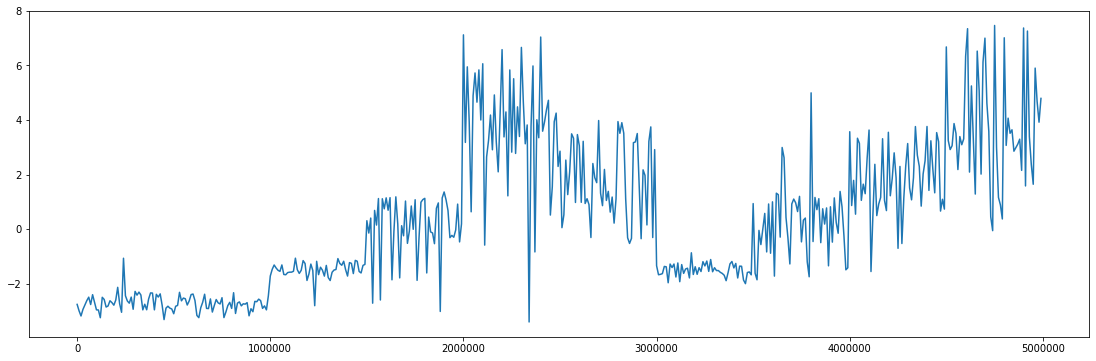

In [0]:
#train['drift_dis'] = train['signal'] - train_c['signal']
plt.plot(train_c['signal'][::10000])

<Figure size 3600x360 with 0 Axes>

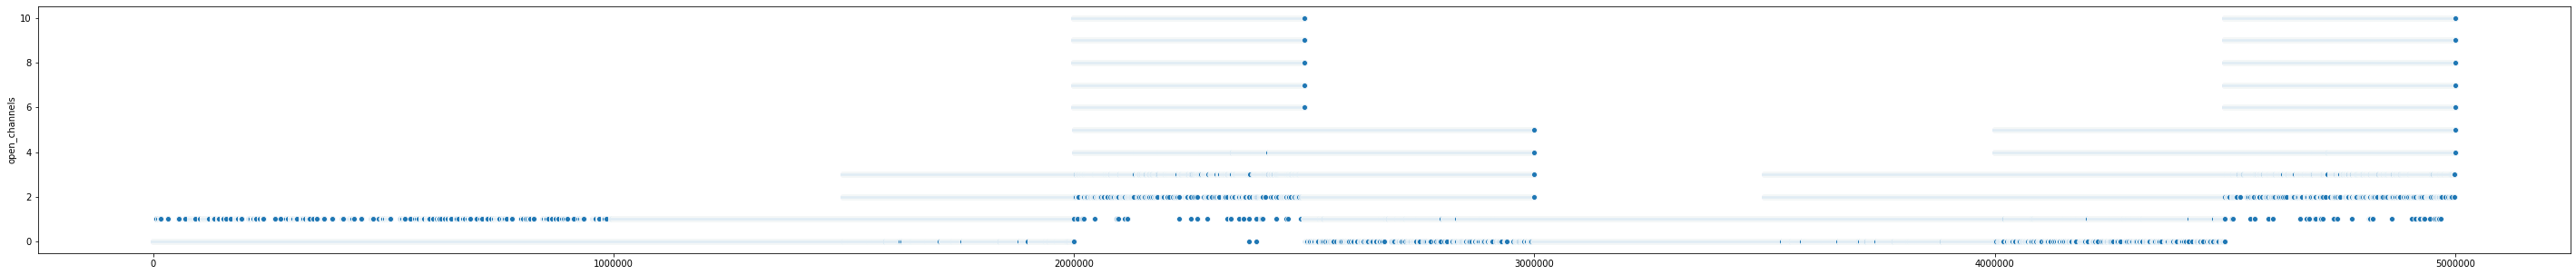

In [0]:
plt.figure(figsize=(50,5))
sns.scatterplot(train.index,train['open_channels'])

In [0]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [0]:
train = get_batch(train)
test = get_batch(test)

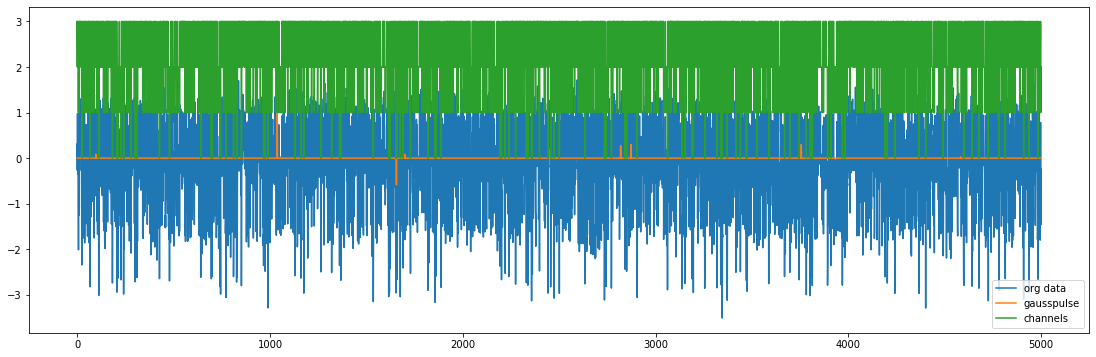

In [0]:
vals_gauss = signal.gausspulse(np.array(train[train['batch'] == 3]['signal'][::100]))
vals_org = train[train['batch'] == 3]['signal'][::100].values
vals_chnls = train[train['batch'] == 3]['open_channels'][::100].values
plt.plot(vals_org,label='org data')
plt.plot(vals_gauss,label='gausspulse')
plt.plot(vals_chnls,label='channels')
plt.legend()

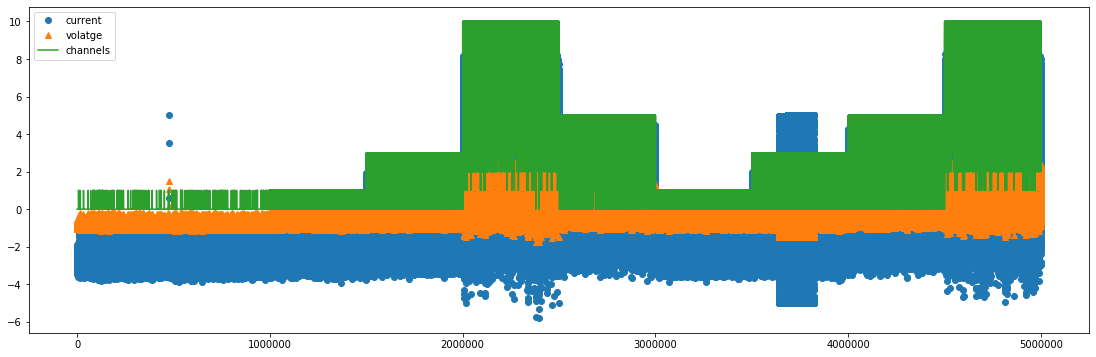

In [0]:
#vals = np.array(train['signal']) * 0.3
plt.plot(train['signal'],'o',label='current')
plt.plot(vals,'^',label='volatge')
plt.plot(train['open_channels'],label='channels')
plt.legend()

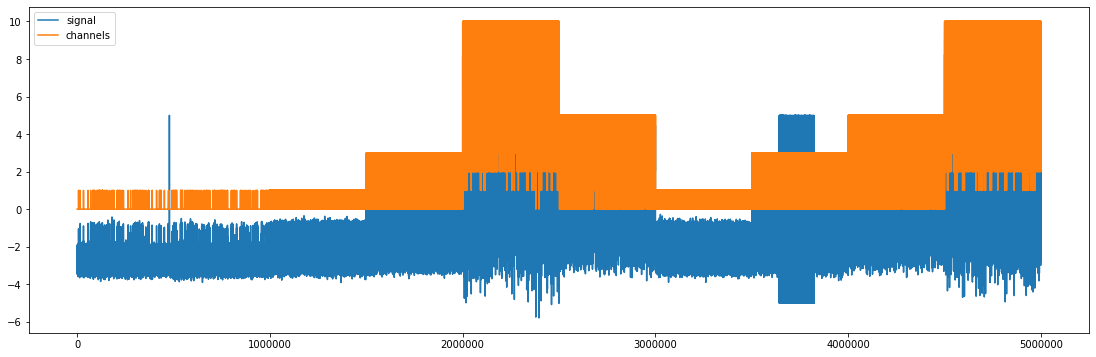

In [0]:
plt.plot(train['signal'],label='signal')
plt.plot(train['open_channels'],label='channels')
plt.legend()

([<matplotlib.axis.XTick at 0x7fa00e9d9e48>,
 <a list of 21 Text xticklabel objects>)

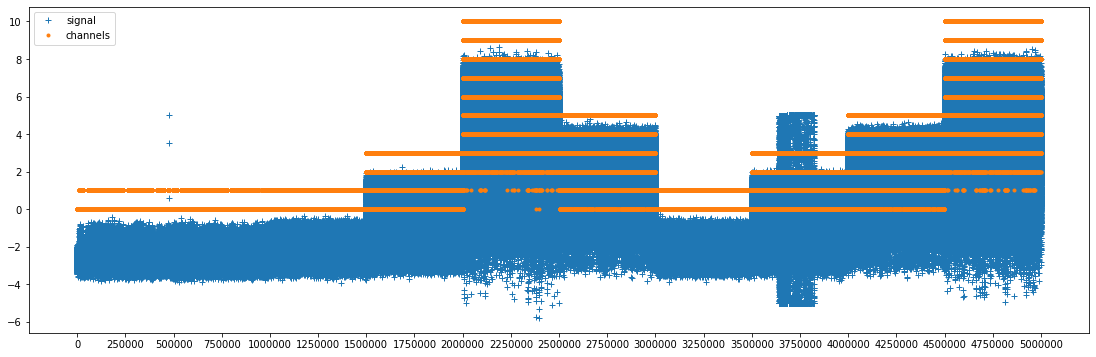

In [0]:
plt.plot(train['signal'],'+',label='signal')
plt.plot(train['open_channels'],'.',label='channels')
plt.xticks(np.linspace(0,5e6,21))
plt.legend()
plt.show()

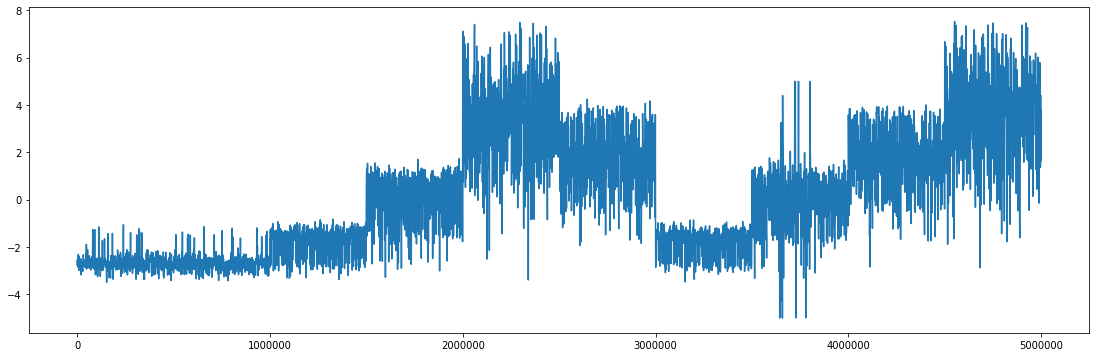

In [0]:
plt.plot(train['signal'][::1000])

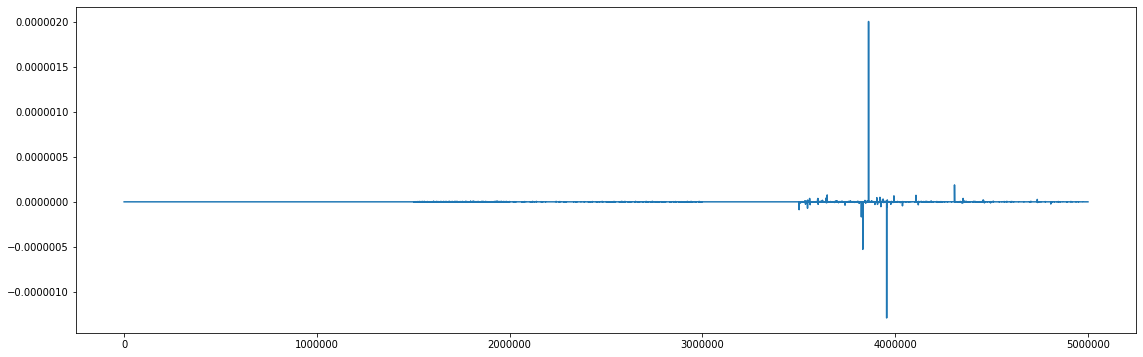

In [0]:
a = np.sqrt(((4*1.308*10e-23)*230*10*10e3/10e9))
train['c'] = a/train['signal']
plt.plot(train['c'],label='noise')

In [0]:
for i in range(11):
  print(i," => ",train[train['batch'] == i]['signal'].mean(),train[train['batch'] == i]['signal'].std())

0  =>  -2.6814063591999635 0.32963037409516827
1  =>  -2.6820955109000515 0.3456105635995572
2  =>  -1.8131248770000243 0.590368728654803
3  =>  -0.09298384680000123 1.0027928262127241
4  =>  3.3578080267999773 1.8182650859136409
5  =>  1.6808369995778851 1.2786635144594118
6  =>  -1.8045712079590595 0.586223918136625
7  =>  -0.11254373272106 1.1704011053827756
8  =>  1.6733502762642023 1.2841900127637067
9  =>  3.350043355606562 1.8191696002399782
10  =>  nan nan


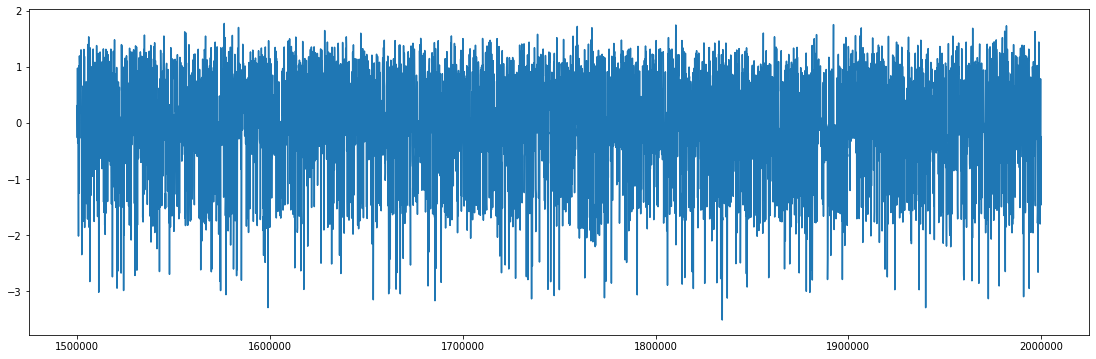

In [0]:
plt.plot(train[train['batch'] == 3]['signal'][::100])

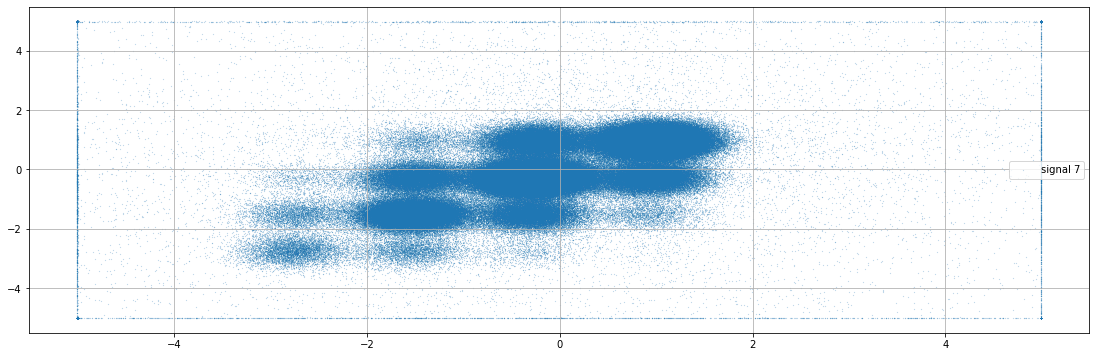

2    0.433318
3    0.363386
1    0.178386
0    0.024908
5    0.000002
Name: open_channels, dtype: float64


In [0]:
i=7
plt.scatter(np.roll(train[train['batch'] == i]['signal'],-1),train[train['batch'] == i]['signal'],s=0.01,label=f'signal {i}')
plt.legend()
plt.grid()
plt.show()
print(train[train['batch'] == i]['open_channels'].value_counts(normalize=True))

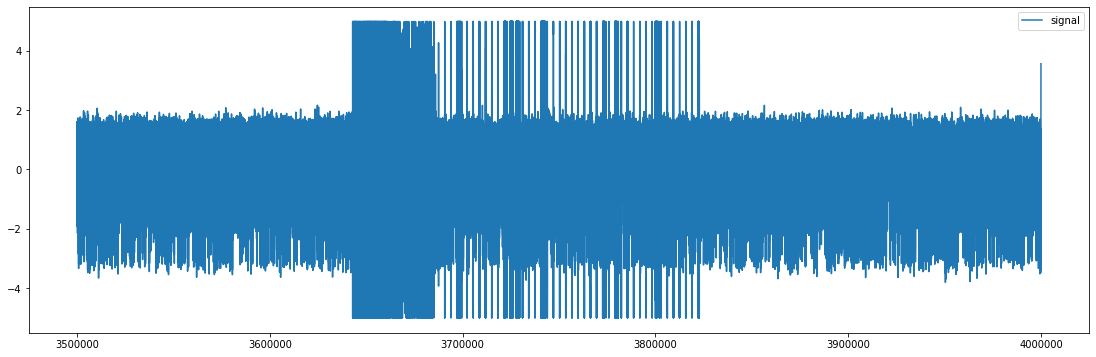

In [0]:
plt.plot(train[train['batch'] == 7]['signal'],label='signal')
plt.legend()
plt.show()

In [0]:
def smooth(x,window_len=11,window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [0]:
a = train.signal.shift(-1) - train.signal

In [0]:
0.19*np.sqrt(2)

0.2687005768508881

In [0]:
train['signal'][:10]
a[:10]

0.0    -2.7600
1.0    -2.8557
2.0    -2.4074
3.0    -3.1404
4.0    -3.1525
5.0    -2.6418
6.0    -2.6993
7.0    -2.5935
8.0    -2.6682
9.0    -2.7586
10.0   -3.1136
Name: signal, dtype: float64

array([-2.57  , -2.6657, -2.2174, -2.9504, -2.9625, -2.4518, -2.5093,
       -2.4035, -2.4782, -2.5686])

<Figure size 1368x360 with 0 Axes>

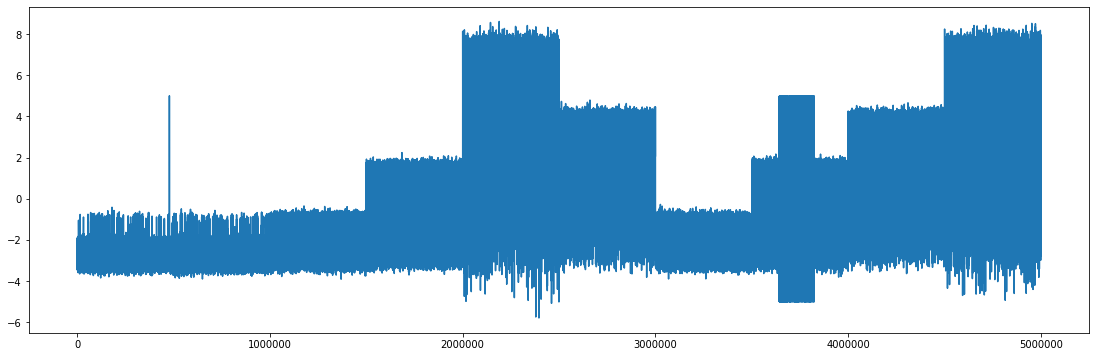

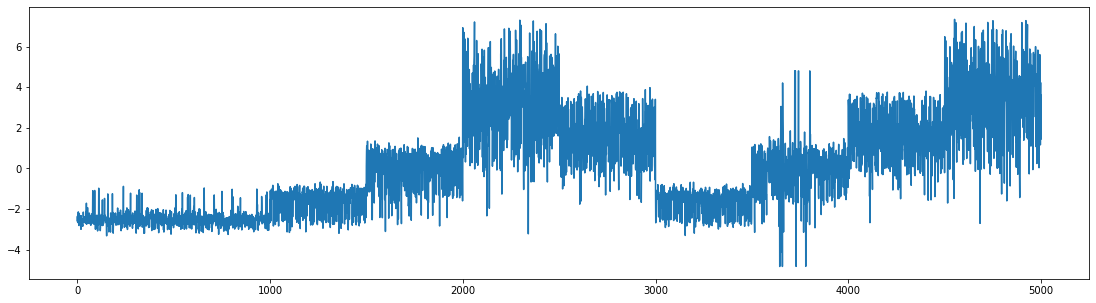

In [0]:
a = np.where(train['signal']<0,train['signal'] + 0.19,train['signal'] - 0.19)
plt.plot(train.signal)
plt.figure(figsize=(19,5))
plt.plot(a[::1000])

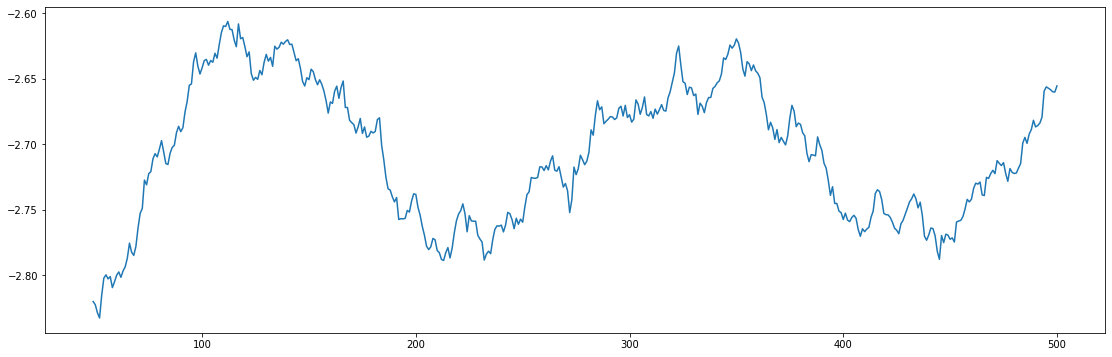

In [0]:
plt.plot(train['signal'][:500].rolling(50).mean(),label='original')

#### For Test Data

In [0]:
test2 = test.copy()

<Figure size 1440x360 with 0 Axes>

Text(525, 5.5, '1')

Text(575, 5.5, '2')

Text(625, 5.5, '3')

Text(675, 5.5, '4')

Text(505, 4, 'A')

Text(515, 4, 'B')

Text(525, 4, 'C')

Text(535, 4, 'D')

Text(545, 4, 'E')

Text(555, 4, 'F')

Text(565, 4, 'G')

Text(575, 4, 'H')

Text(585, 4, 'I')

Text(595, 4, 'J')

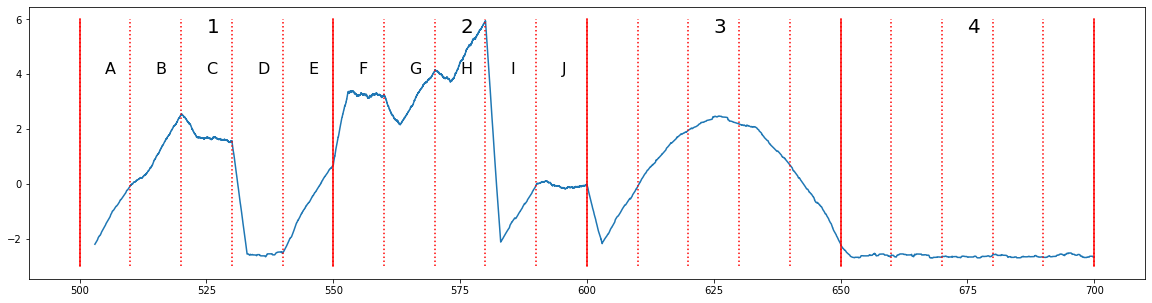

In [0]:
plt.figure(figsize=(20,5))
let = ['A','B','C','D','E','F','G','H','I','J']
r = test.signal.rolling(30000).mean()
plt.plot(test.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-3,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-3,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.show()

In [0]:
a = 0;b=100000
slope, intercept, _, _, _ = stats.linregress(test.loc[test.index[a:b],'time'], test2.signal.values[a:b])

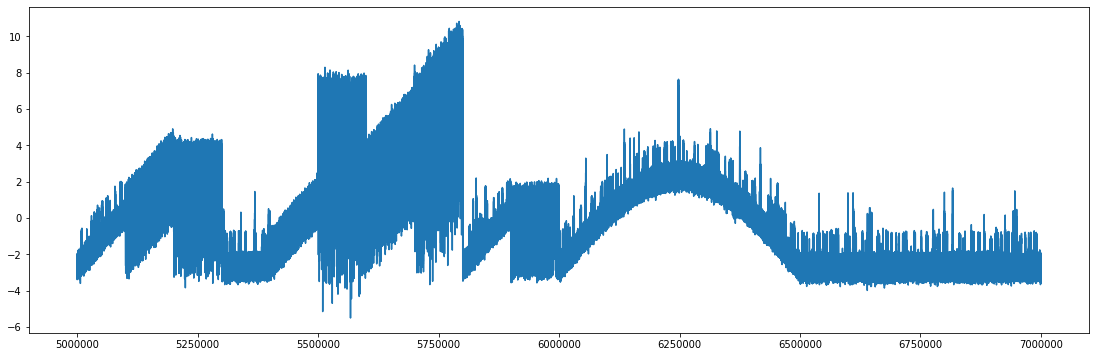

In [0]:
test2.loc[a:b,'signal'] = test2.loc[a:b,'signal'] - (np.round(slope,2)*test2.loc[a:b,'time']) + intercept
plt.plot(test2['signal'])

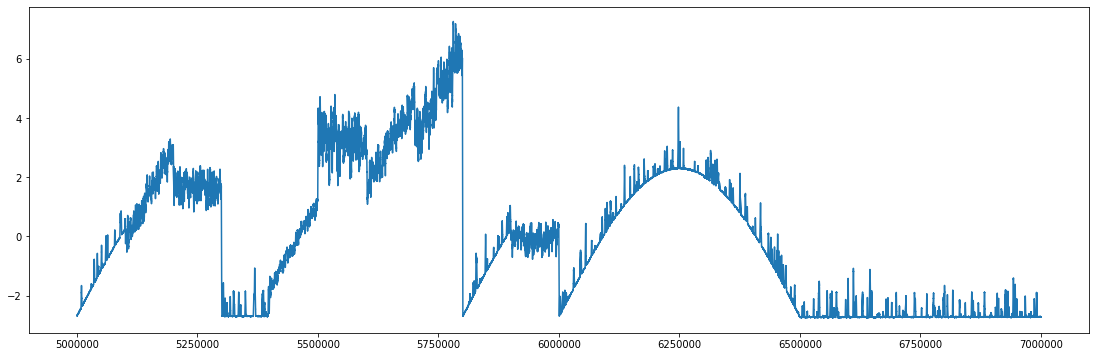

In [0]:
plt.plot(test['signal'].rolling(1000).mean())

# Garbage

In [0]:
def get_features(df):
    df['rolling_signal_mean'] = df['signal'].rolling(10,min_periods=1).mean()
    df['rolling_signal_median'] = df['signal'].rolling(10,min_periods=1).median()

    for x in tqdm_notebook(['batch','batch_slices2']):
      sig_mean = df.groupby(x)['signal'].mean().to_dict()
      sig_median = df.groupby(x)['signal'].median().to_dict()
      sig_std = df.groupby(x)['signal'].std().to_dict()
      sig_max = df.groupby(x)['signal'].max().to_dict()
      sig_min = df.groupby(x)['signal'].min().to_dict()
      sig_mean_abs_diff = df.groupby(x)['signal'].apply(lambda x: np.mean(np.absolute(np.diff(x)))).to_dict()
      sig_mean_non_abs_diff = df.groupby(x)['signal'].apply(lambda x:np.mean(np.diff(x))).to_dict()
      sig_skew = df.groupby(x)['signal'].skew().to_dict()
      sig_kurt = df.groupby(x)['signal'].apply(pd.DataFrame.kurt).to_dict()
      sig_kurt_zscore = {x:y[0] for (x,y) in df.groupby(x)['signal'].apply(stats.kurtosistest).to_dict().items()}
      sig_kurt_pvalue = {x:y[0] for (x,y) in df.groupby(x)['signal'].apply(stats.kurtosistest).to_dict().items()}
      sig_sem = df.groupby(x)['signal'].apply(stats.sem).to_dict()
      sig_skew_zscore = {x:y[0] for (x,y) in df.groupby(x)['signal'].apply(stats.skewtest).to_dict().items()}
      sig_skew_pvalue = {x:y[1] for (x,y) in df.groupby(x)['signal'].apply(stats.skewtest).to_dict().items()}
      sig_zscore_mean = {x:np.mean(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_max = {x:np.max(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_min = {x:np.min(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_std = {x:np.std(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_var = {x:np.var(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_median = {x:np.median(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_relfreq_freq_mean = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_median = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_max = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_min = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_std = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_var = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_lower_limit = {x:y[1] for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_binsize = {x:y[2] for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}

      sig_variance = df.groupby(x)['signal'].var().to_dict()

      if x is not 'batch':
        sig_mad = df.groupby(x)['signal'].apply(mean_abs_dev).to_dict()
        sig_sum = df.groupby(x)['signal'].sum().to_dict()
        df[f'{x}_sig_mad'] = df[x].map(sig_mad)
        df[f'{x}_sig_sum'] = df[x].map(sig_sum)

      df[f'{x}_sig_mean'] =  df[x].map(sig_mean)
      df[f'{x}_sig_median'] =  df[x].map(sig_median)
      df[f'{x}_sig_std'] = df[x].map(sig_std)
      df[f'{x}_sig_max'] =  df[x].map(sig_max)
      df[f'{x}_sig_min'] =  df[x].map(sig_min)
      df[f'{x}_sig_abs_max'] = 0 - df[f'{x}_sig_min']
      df[f'{x}_sig_abs_min'] = 0 - df[f'{x}_sig_max']
      df[f'{x}_sig_mean_abs_diff'] = df[x].map(sig_mean_abs_diff)
      df[f'{x}_sig_mean_non_abs_diff'] = df[x].map(sig_mean_non_abs_diff)
      df[f'{x}_range'] = df[f'{x}_sig_max'] - df[f'{x}_sig_min']
      df[f'{x}_max_by_min'] = df[f'{x}_sig_max'] / df[f'{x}_sig_min']
      df[f'{x}_abs_min_max_avg'] = (df[f'{x}_sig_abs_max'] + df[f'{x}_sig_abs_min'])/2.0
      df[f'{x}_min_max_avg'] = (df[f'{x}_sig_max'] + df[f'{x}_sig_min'])/2.0
      df[f'{x}_sig_shift_pos'] = df.groupby(x)['signal'].shift()
      df[f'{x}_sig_shift_neg'] = df.groupby(x)['signal'].shift(-1)
      df[f'{x}_max_to_abs_min_diff'] = df[f'{x}_sig_max'] - np.absolute(df[f'{x}_sig_min'])
      df[f'{x}_sig_kurtosis'] = df[x].map(sig_kurt)
      df[f'{x}_sig_skew'] = df[x].map(sig_skew)
      df[f'{x}_sig_kurt_zscore'] = df[x].map(sig_kurt_zscore)
      df[f'{x}_sig_kurt_pvalue'] = df[x].map(sig_kurt_pvalue)
      df[f'{x}_sig_skew_zscore'] = df[x].map(sig_skew_zscore)
      df[f'{x}_sig_skew_pvalue'] = df[x].map(sig_skew_pvalue)
      df[f'{x}_sig_sem'] = df[x].map(sig_sem)
      df[f'{x}_sig_zscore_mean'] = df[x].map(sig_zscore_mean)
      df[f'{x}_sig_zscore_min'] = df[x].map(sig_zscore_min)
      df[f'{x}_sig_zscore_max'] = df[x].map(sig_zscore_max)
      df[f'{x}_sig_zscore_median'] = df[x].map(sig_zscore_median)
      df[f'{x}_sig_zscore_std'] = df[x].map(sig_zscore_std)
      df[f'{x}_sig_zscore_var'] = df[x].map(sig_zscore_var)
      df[f'{x}_sig_relfreq_freq_mean'] = df[x].map(sig_relfreq_freq_mean)
      df[f'{x}_sig_relfreq_freq_min'] = df[x].map(sig_relfreq_freq_min)
      df[f'{x}_sig_relfreq_freq_max'] = df[x].map(sig_relfreq_freq_max)
      df[f'{x}_sig_relfreq_freq_std'] = df[x].map(sig_relfreq_freq_std)
      df[f'{x}_sig_relfreq_freq_median'] = df[x].map(sig_relfreq_freq_median)
      df[f'{x}_sig_relfreq_freq_var'] = df[x].map(sig_relfreq_freq_var)
      df[f'{x}sig_relfreq_lower_limit'] = df[x].map(sig_relfreq_lower_limit)
      df[f'{x}_sig_relfreq_binsize'] = df[x].map(sig_relfreq_binsize)

      
      if x is not 'batch':
        df[f'{x}_abs_min_range_from_mean'] = df[f'{x}_sig_abs_min'] - df[f'{x}_sig_mean']
        df[f'{x}_abs_max_range_from_mean'] = df[f'{x}_sig_abs_max'] - df[f'{x}_sig_mean']
        df[f'{x}_abs_min_range_from_mad'] = df[f'{x}_sig_abs_min'] - df[f'{x}_sig_mad']
        df[f'{x}_abs_max_range_from_mad'] = df[f'{x}_sig_abs_max'] - df[f'{x}_sig_mad']


    df['signal_rolling_10_sum'] = df['signal'].rolling(10,min_periods=1).sum()
    df['signal_rolling_10_mean'] = df['signal'].rolling(10,min_periods=1).mean()
    df['signal_shift_pos'] = df['signal'].shift()
    df['signal_shift_neg'] = df['signal'].shift(-1)

    for c in [c for c in df.columns if c not in ['time','signal','open_channels','batch_index','batch','batch_slices2','batch_slices']]:
      df[f'{c}_msignal'] = df[c] - df['signal']
    return df